# Retrieval of a Methane High-Resolution Emission Spectrum

In this tutorial, we try to fit the ExoJAX emission model to a mock high-resolution spectrum. This spectrum was computed assuming a powerlaw temperature profile and CH4 opacity + CIA. 

In this tutorial, we use PreMODIT as an opacity calculator.

Note that the python file is available in tests/endtoend/reverse/reverse_premodit.ipynb 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp

import pandas as pd
import pkg_resources

from exojax.spec.atmrt import ArtEmisPure
from exojax.spec.api import MdbExomol
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA
from exojax.spec.specop import SopRotation
from exojax.spec.specop import SopInstProfile
from exojax.spec import molinfo
from exojax.spec.unitconvert import nu2wav
from exojax.utils.grids import wavenumber_grid
from exojax.utils.astrofunc import gravity_jupiter
from exojax.utils.instfunc import resolution_to_gaussian_std
from exojax.test.data import SAMPLE_SPECTRA_CH4_NEW

/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


We use numpyro as a probabilistic programming language (PPL). We have other options such as BlackJAX, PyMC etc.

In [2]:
# PPL
import arviz
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

Use FP64 just in case.

In [3]:
from jax.config import config

config.update("jax_enable_x64", True)

We use a sample data of the methane emission spectrum in ExoJAX, normlized it, and add Gaussian noise.

In [4]:
# loading the data
filename = pkg_resources.resource_filename(
    'exojax', 'data/testdata/' + SAMPLE_SPECTRA_CH4_NEW)
dat = pd.read_csv(filename, delimiter=",", names=("wavenumber", "flux"))
nusd = dat['wavenumber'].values
flux = dat['flux'].values
wavd = nu2wav(nusd)

sigmain = 0.05
norm = 20000
nflux = flux / norm + np.random.normal(0, sigmain, len(wavd))

We first set the wavenumber grid enough to cover the observed spectrum. Also, make "art" (Atmospheric Radiative Transfer) object. beta_inst is a STD of instrumental resolution. 

In [5]:

Nx = 7500
nu_grid, wav, res = wavenumber_grid(np.min(wavd) - 10.0,
                                    np.max(wavd) + 10.0,
                                    Nx,
                                    unit='AA',
                                    xsmode='premodit')

Tlow = 400.0
Thigh = 1500.0
art = ArtEmisPure(nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=100)
art.change_temperature_range(Tlow, Thigh)
Mp = 33.2

Rinst = 100000.
beta_inst = resolution_to_gaussian_std(Rinst)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit


/home/kawahara/exojax/src/exojax/utils/grids.py:126: UserWarning: Resolution may be too small. R=617160.1067701889
  warnings.warn('Resolution may be too small. R=' + str(resolution),


As usual, we make "mdb" and "opa" for CH4. Because CH4 has a lot of lines, we use PreMODIT as an opacity calculator. 

In [6]:
### CH4 setting (PREMODIT)
mdb = MdbExomol('.database/CH4/12C-1H4/YT10to10/',
                nurange=nu_grid,
                gpu_transfer=False)
print('N=', len(mdb.nu_lines))
diffmode = 0
opa = OpaPremodit(mdb=mdb,
                  nu_grid=nu_grid,
                  diffmode=diffmode,
                  auto_trange=[Tlow, Thigh],
                  dit_grid_resolution=0.2)

/home/kawahara/exojax/src/exojax/utils/molname.py:133: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:49: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.",UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:49: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.",UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:28: UserWarning: exact molecule name is not Exomol nor HITRAN form.
  warnings.warn("exact molecule name is not Exomol nor HITRAN form.")
/home/kawahara/exojax/src/exojax/spec/molinfo.py:29: UserWarning: No molmass available
  warnings.warn("No molmass available", UserWarning)


HITRAN exact name= (12C)(1H)4
HITRAN exact name= (12C)(1H)4
Background atmosphere:  H2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06000-06100.trans.bz2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06100-06200.trans.bz2
.broad is used.
Broadening code level= a1
default broadening parameters are used for  23  J lower states in  40  states
N= 80505310
OpaPremodit: params automatically set.
Robust range: 397.77407283130566 - 1689.7679243628259 K
Tref changed: 296.0K->1153.6267095763965K
Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  3
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Premodit: Twt= 461.3329793405918 K Tref= 1153.6267095763965 K
Making LSD:|####################| 100%


As a continuum model, we assume CIA (H2 vs H2).

In [7]:

## CIA setting
cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)
opcia = OpaCIA(cdb=cdbH2H2, nu_grid=nu_grid)
mmw = 2.33  # mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass_isotope('H2')
vmrH2 = (mmrH2 * mmw / molmassH2)  # VMR

H2-H2


Then, we make a function that computes the model spectrum.

In [8]:

#settings spectral operators
sop_rot = SopRotation(nu_grid,res,vsini_max=100.0)
sop_inst = SopInstProfile(nu_grid,res,vrmax=100.0)

def frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini):
    g = gravity_jupiter(Rp=Rp, Mp=Mp)  # gravity in the unit of Jupiter
    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(MMR_CH4)
    dtaumCH4 = art.opacity_profile_lines(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opcia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtaumCH4 + dtaucH2H2
    F0 = art.run(dtau, Tarr) / norm
    Frot = sop_rot.rigid_rotation(F0, vsini, u1, u2)
    Frot_inst = sop_inst.ipgauss(Frot, beta_inst)
    mu = sop_inst.sampling(Frot_inst, RV, nusd)
    return mu

/home/kawahara/exojax/src/exojax/utils/grids.py:126: UserWarning: Resolution may be too small. R=617160.1067701889
  warnings.warn('Resolution may be too small. R=' + str(resolution),
/home/kawahara/exojax/src/exojax/utils/grids.py:126: UserWarning: Resolution may be too small. R=617160.1067701889
  warnings.warn('Resolution may be too small. R=' + str(resolution),


The following is the numpyro model, i.e. prior and sample.

In [9]:
def model_c(y1):
    Rp = numpyro.sample('Rp', dist.Uniform(0.4, 1.2))
    RV = numpyro.sample('RV', dist.Uniform(5.0, 15.0))
    MMR_CH4 = numpyro.sample('MMR_CH4', dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0, 25.0))
    u1 = 0.0
    u2 = 0.0
    Tarr = art.powerlaw_temperature(T0, alpha)
    mu = frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini)
    numpyro.sample('y1', dist.Normal(mu, sigmain), obs=y1)

Let's run the HMC-NUTS. In my environment, it took ~2 hours using A100.

In [10]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_c, forward_mode_differentiation=True)
kernel = NUTS(model_c, forward_mode_differentiation=False)

mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, y1=nflux)
mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [2:05:21<00:00,  5.01s/it, 511 steps of size 4.43e-03. acc. prob=0.94]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   MMR_CH4      0.01      0.00      0.01      0.00      0.01    290.23      1.03
        RV      9.82      0.37      9.82      9.13     10.37    418.62      1.00
        Rp      0.79      0.19      0.76      0.52      1.10    275.86      1.03
        T0   1187.71     15.85   1187.52   1160.36   1211.58    631.57      1.00
     alpha      0.10      0.00      0.10      0.09      0.11    503.47      1.01
     vsini     19.42      0.70     19.43     18.40     20.68    620.75      1.00

Number of divergences: 0


Sampling...

In [11]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c, posterior_sample, return_sites=['y1'])
predictions = pred(rng_key_, y1=None)
median_mu1 = jnp.median(predictions['y1'], axis=0)
hpdi_mu1 = hpdi(predictions['y1'], 0.9)

O.K!, Plot the prediction!

In [14]:
# PLOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6.0))
ax.plot(wavd[::-1], median_mu1, color='C0')
ax.plot(wavd[::-1], nflux, '+', color='black', label='data')
ax.fill_between(wavd[::-1],
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C0',
                label='90% area')
plt.xlabel('wavelength ($\AA$)', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("pred_diffmode" + str(diffmode) + ".png")
#plt.show()
plt.close()

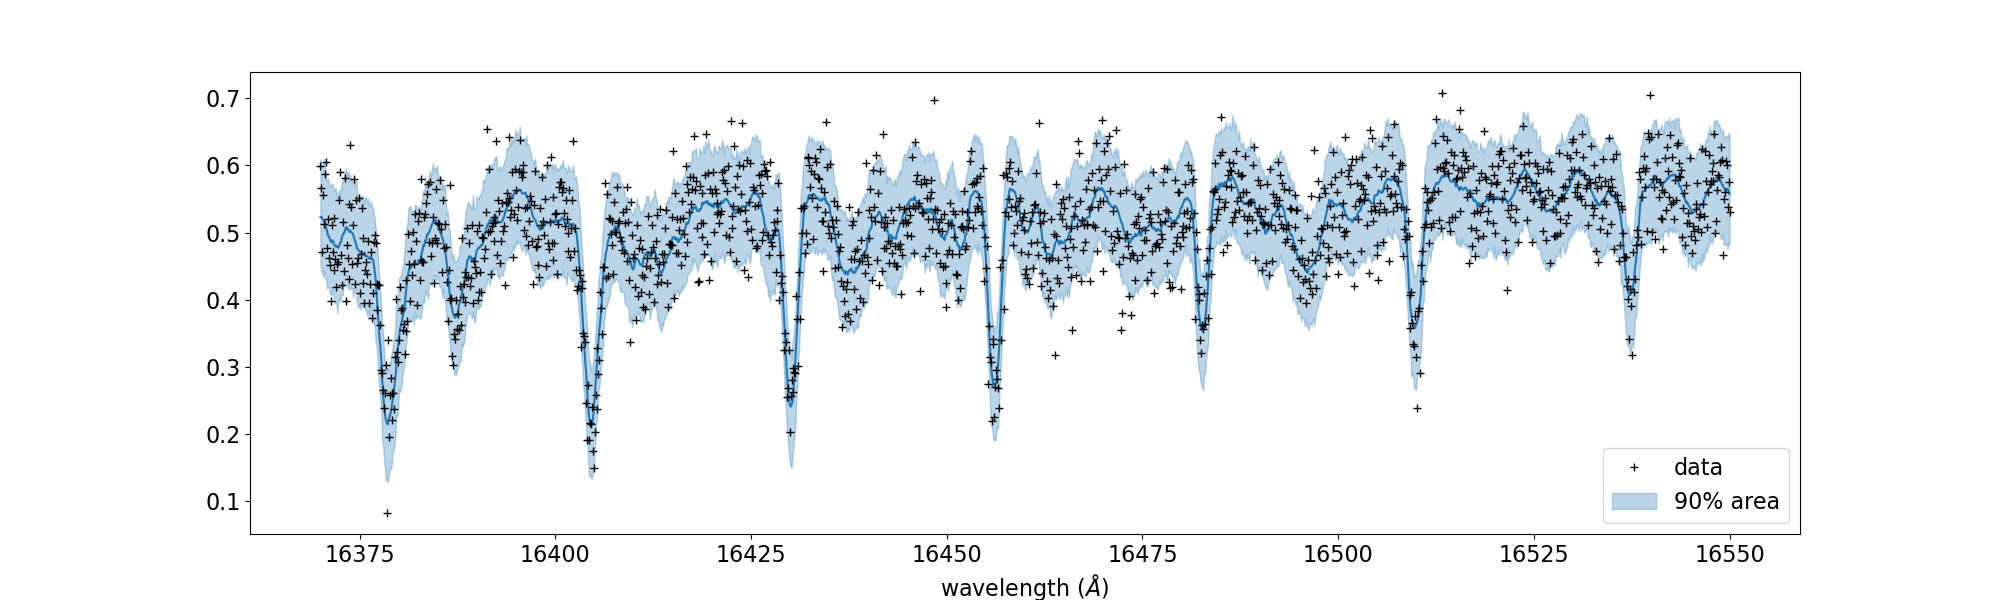

In [15]:
from IPython.display import Image
Image("pred_diffmode0.png")

Looks good. How about the contour plot?

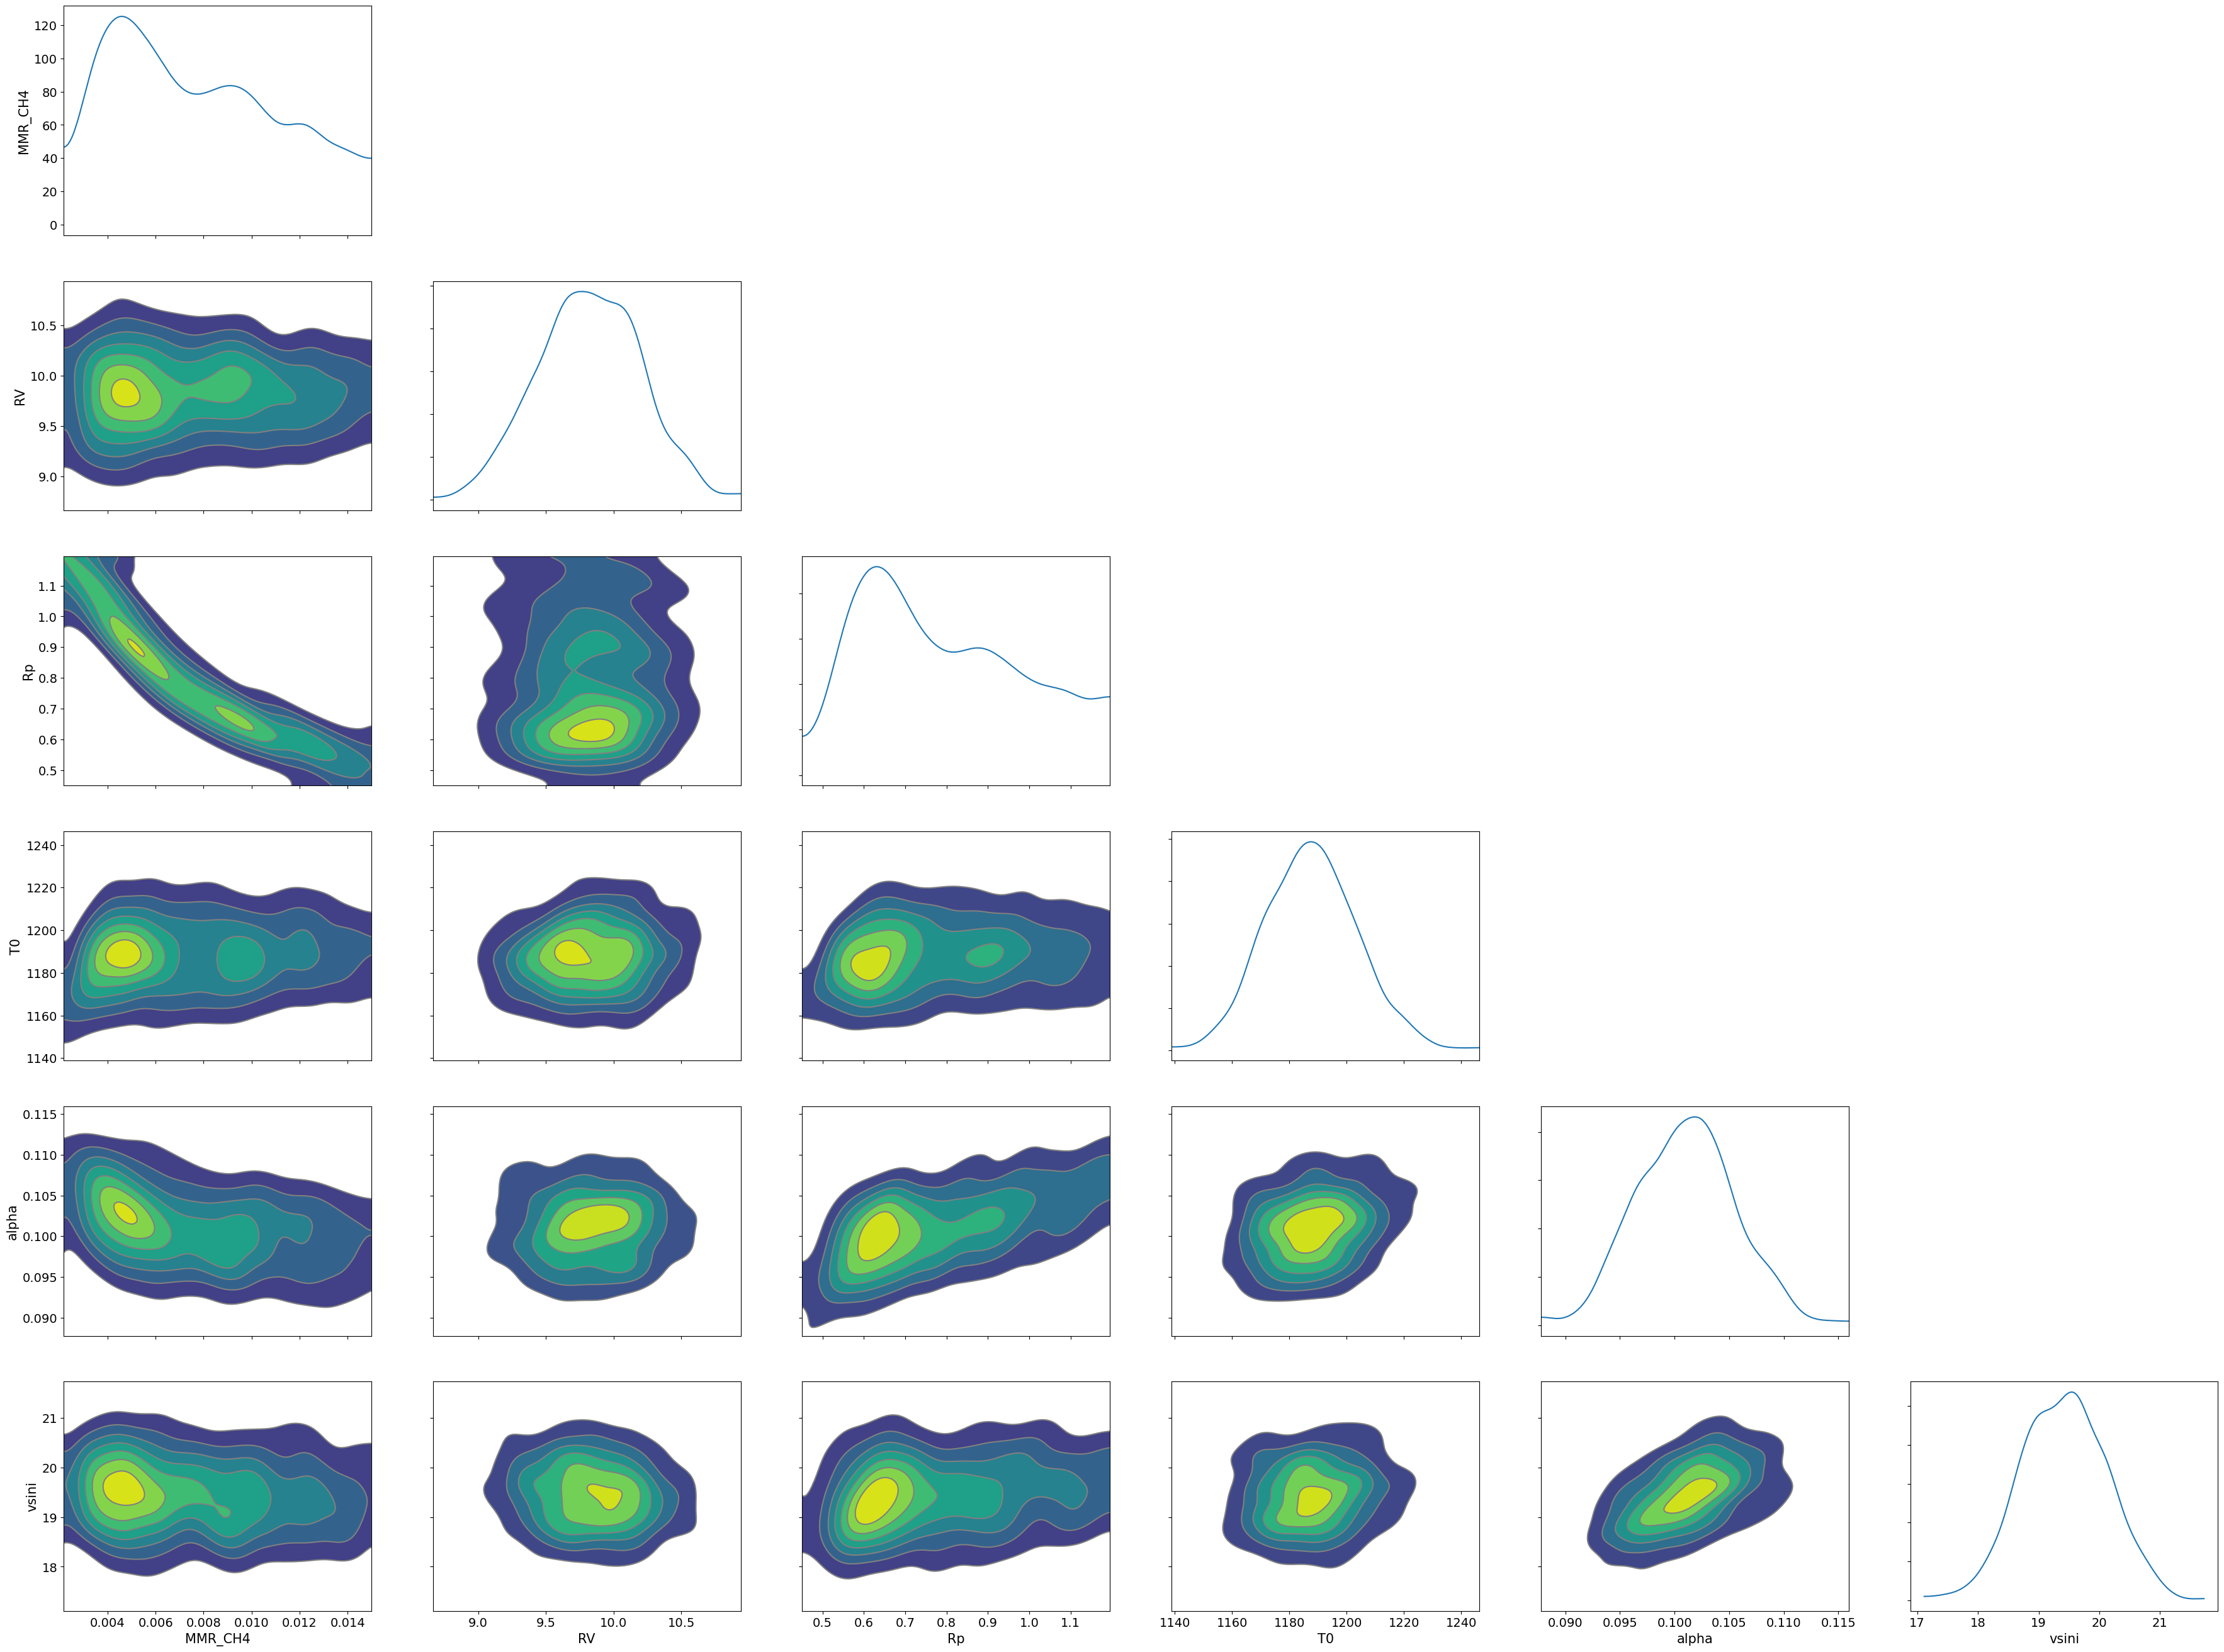

In [18]:

pararr = ['Rp', 'T0', 'alpha', 'MMR_CH4', 'vsini', 'RV']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=True,
                marginals=True)
plt.savefig("corner_diffmode" + str(diffmode) + ".png")

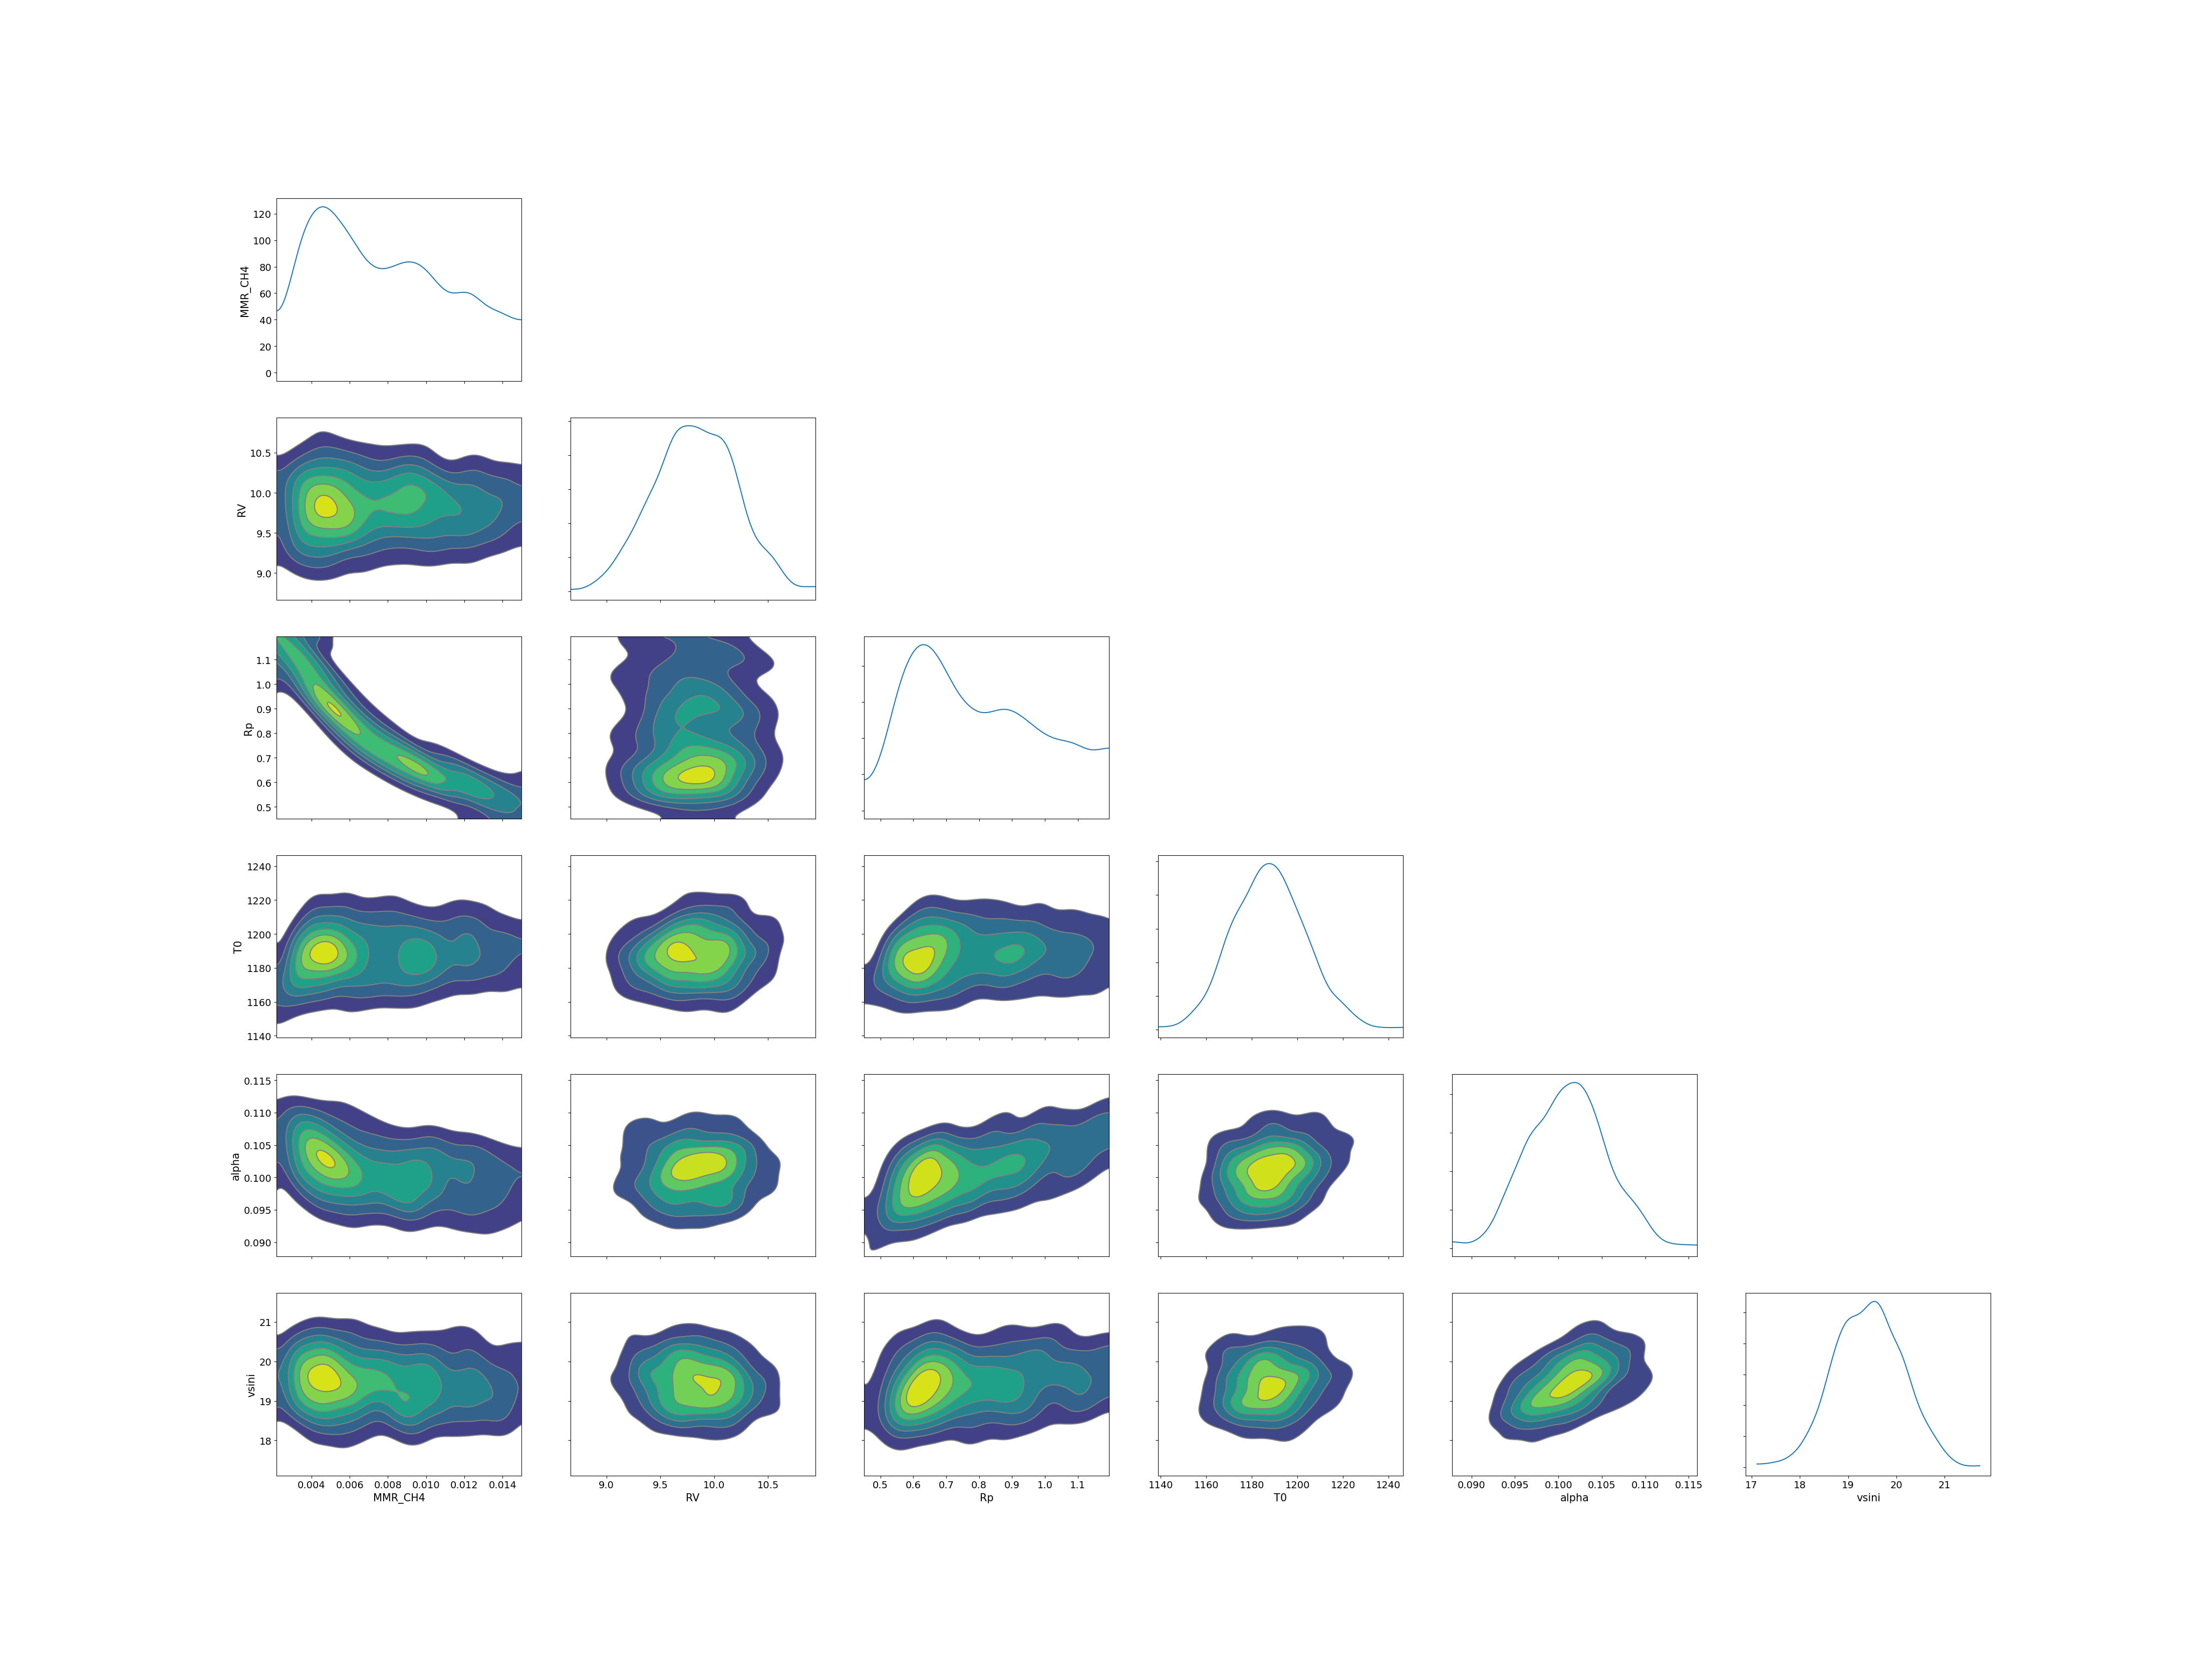

In [17]:
Image("corner_diffmode0.png")

That's it!